Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
import warnings

# 🔵 Disable warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import tensorflow as tf

# Set reproducible random seed
np.random.seed(123)
tf.random.set_seed(123)

### Importing all the important libraries

In [3]:
import pathlib  # Provides an easy way to work with file system paths
import tensorflow as tf  # TensorFlow is a deep learning framework
import matplotlib.pyplot as plt  # Used for plotting and visualizing data
import numpy as np  # Library for numerical computations
import pandas as pd  # Library for handling data in DataFrame format

# os module helps in interacting with the operating system for file paths, etc.
import os  

# PIL is the Python Imaging Library, used here for handling image files
import PIL

# TensorFlow Keras provides high-level API for building neural networks
from tensorflow import keras  

# Import layers module from Keras to facilitate various building blocks (e.g., Dense, Conv2D)
from tensorflow.keras import layers   

# Sequential is used to build sequential models (a stacked series of layers)
from tensorflow.keras.models import Sequential  

# os ensures interaction with directories or file structures
import os  

# glob is used for finding all the file paths matching a specified pattern
from glob import glob  

# Callbacks for saving models and implementing early stopping criteria
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  

# Re-import Matplotlib for plotting figures (used implicitly in many scenarios)
import matplotlib.pyplot as plt  

# Seaborn is another visualization library built on top of Matplotlib
import seaborn as sns  

# Commonly used layers in Convolutional Neural Networks (CNN)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, Activation, MaxPooling2D, Rescaling  

# Utility function to normalize data (e.g., ensuring RGB pixel values lie between 0 and 1)
from tensorflow.keras.utils import normalize, plot_model

# ImageDataGenerator is used for augmenting image data on the fly for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator   

# Import EarlyStopping functionality again (for automatically stopping training if a metric doesn't improve for a given number of epochs)
from tensorflow.keras.callbacks import EarlyStopping

# Import necessary libraries
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomFlip, RandomTranslation

# At this point, you'd typically start building your model or preparing your dataset.
# The above imports cover essential libraries for building a Convolutional Neural Network (CNN) model, loading data (images), and visualizing results (plotting).


### Importing Skin Cancer Data
#### Uploaded the dataset to kaggle from google drive

In [4]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b0166

### Using our custom Kaggle Dataset in this notebook

In [5]:
# Defining the path for train and test images
## paths of the train and test dataset
data_dir_train = pathlib.Path("/kaggle/input/av-cnn-melonoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/kaggle/input/av-cnn-melonoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful `image_dataset_from_directory`utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                           image_size = (img_height, img_width),
                                                           validation_split = 0.2,
                                                           subset = "training",seed=123,batch_size=32,labels='inferred',
                                                           color_mode = 'rgb',
                                                           shuffle = True)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                           image_size = (img_height, img_width),
                                                           validation_split = 0.2,
                                                           subset = "validation",seed=123,batch_size=32,labels='inferred',
                                                           color_mode = 'rgb',
                                                           shuffle = True)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize samples from the training data
#### Code to visualize one instance of all the nine classes present in the dataset

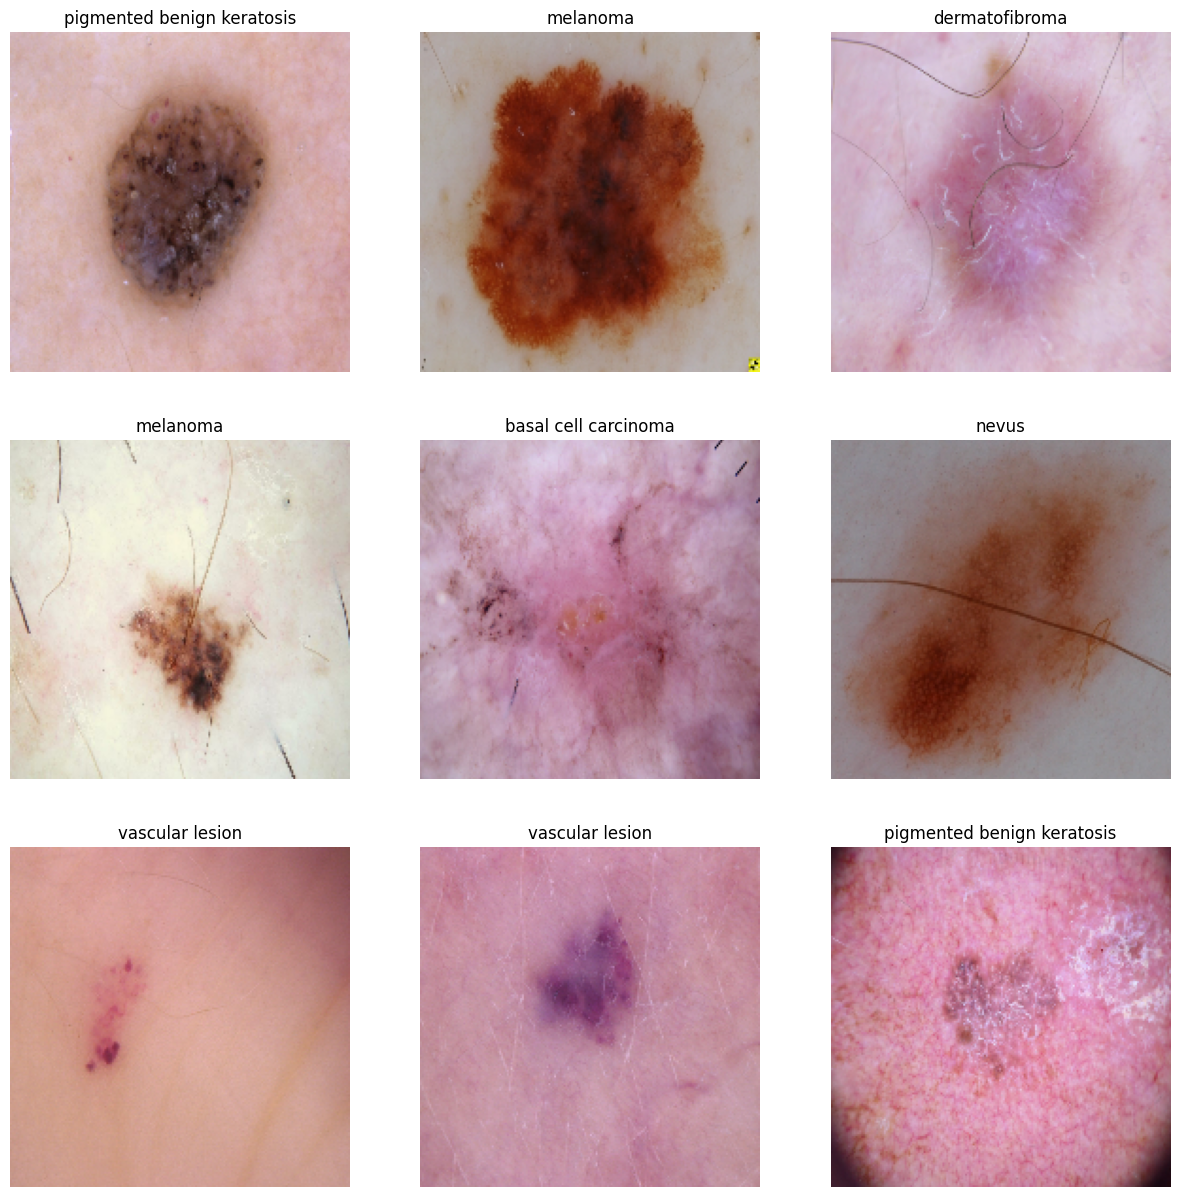

In [11]:
# Fetch a batch of training images and labels
plt.figure(figsize=(15, 15))

for images, labels in train_ds.take(1):  # .take(1) fetches one batch of data
    for i in range(9):  # To visualize 9 classes 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

#### Util function to count images based on class label

In [12]:
def count_images_based_on_class(data_dir):

    count= []
    for path in pathlib.Path(data_dir).iterdir():
        if path.is_dir():

          count.append(len([name for name in os.listdir(path)
                if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(data_dir)
                    if os.path.isdir(os.path.join(data_dir, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'Count_of_Images'])

In [13]:
train_df=count_images_based_on_class(data_dir_train)
train_df

Class_Name  Count_of_Images
0  pigmented benign keratosis              462
1                    melanoma              438
2             vascular lesion              139
3           actinic keratosis              114
4     squamous cell carcinoma              181
5        basal cell carcinoma              376
6        seborrheic keratosis               77
7              dermatofibroma               95
8                       nevus              357

In [14]:
test_df=count_images_based_on_class(data_dir_test)
test_df

Class_Name  Count_of_Images
0  pigmented benign keratosis               16
1                    melanoma               16
2             vascular lesion                3
3           actinic keratosis               16
4     squamous cell carcinoma               16
5        basal cell carcinoma               16
6        seborrheic keratosis                3
7              dermatofibroma               16
8                       nevus               16

#### Finding the distribution of classes in the training dataset.
##### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Training Data Distribution
Test Data Distribution


<Axes: xlabel='Count_of_Images', ylabel='Class_Name'>

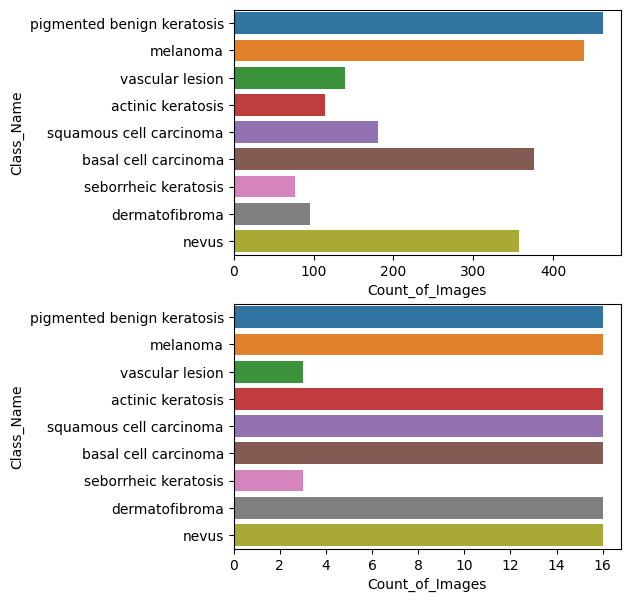

In [15]:

plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
print("Training Data Distribution")
sns.barplot(x="Count_of_Images", y="Class_Name", data=train_df,
            label="Class_Name")
plt.subplot(2,1,2)
print("Test Data Distribution")
sns.barplot(x="Count_of_Images", y="Class_Name", data=test_df,
            label="Class")

####  Observations from Dataset at high level: 
#### - Which class has the least number of samples?

From both charts, it's noticeable that the vascular lesion class has the least number of samples.

seborrheic keratosis has approximately 77 samples, in the training dataset.

#### - Which classes dominate the data in terms proportionate number of samples?
The classes that dominate the data in terms of the proportionate number of samples are:

* Pigmented benign keratosis
* Melanoma
* Basal cell carcinoma
These three classes have the highest counts in both the training and testing datasets.

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### CNN model, which can accurately detect 9 classes present in the dataset. Using ```Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
input_shape = (180,180,3)
lr = 1e-3
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(7, 7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dense (9, activation='softmax'))


model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 83, 83, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 83, 83, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 41, 41, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 31, 128)    │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    14,746,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,844,169 (60.44 MB)

 Trainable params: 15,843,785 (60.44 MB)

 Non-trainable params: 384 (1.50 KB)

In [18]:
# Multi-class Classification
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

### Adding Early Stopping to reduce overfitting

In [19]:
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)


In [20]:
def train_model(model,epochs=10, train_ds=train_ds, valid_ds=val_ds):
    return model.fit(train_ds, validation_data=valid_ds,
                    epochs=epochs,callbacks=[earlystop])


In [21]:
history = train_model(model, 20)

Epoch 1/20


I0000 00:00:1726634781.044946     112 service.cc:145] XLA service 0x57817118ec00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726634781.044991     112 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726634781.044994     112 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 3/56 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2066 - loss: 11.0668 

I0000 00:00:1726634789.567274     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.2669 - loss: 18.5860 - val_accuracy: 0.0492 - val_loss: 22.5387
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3655 - loss: 8.3035 - val_accuracy: 0.1969 - val_loss: 17.2263
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4341 - loss: 4.9248 - val_accuracy: 0.2752 - val_loss: 5.8060
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4687 - loss: 3.1102 - val_accuracy: 0.2394 - val_loss: 4.3383
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5291 - loss: 2.4969 - val_accuracy: 0.2483 - val_loss: 4.7936
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5717 - loss: 1.5445 - val_accuracy: 0.3289 - val_loss: 2.6074
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6290 - loss: 1.0656 - val_accuracy: 0.3624 - val_loss: 3.9105
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7192 - loss: 0.8824 - val_accuracy: 0.4609 - val_los

In [22]:
len(history.history['accuracy'])

20

### Util function for plotting training accuracy and loss

In [23]:
# def plot_training_history(history, epochs = 10):
#     """
#     Plots the training and validation accuracy/loss for model history.

#     Parameters:
#     - history: the history object from a Keras model after training (history.history attribute should exist)
#     - epochs: the number of epochs used during training (or total epochs to plot)
#     """

#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']

#     loss = history.history['loss']
#     val_loss = history.history['val_loss']

#     # Creating ranges for each epoch
#     epochs_range = range(epochs)

#     # Plotting Training and Validation Accuracy and Loss
#     plt.figure(figsize=(8, 8))

#     # Training and Validation Accuracy (Left Subplot)
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2, color='lightblue')  # ⬅️ added color
#     plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2, color='orange')  # ⬅️ added color
#     plt.legend(loc='lower right')
#     plt.title('Training and Validation Accuracy')

#     # Training and Validation Loss (Right Subplot)
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs_range, loss, label='Training Loss', linewidth=2, color='lightgreen')  # ⬅️ added color
#     plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2, color='red')  # ⬅️ added color
#     plt.legend(loc='upper right')
#     plt.title('Training and Validation Loss')

#     plt.show()

In [24]:


def plot_training_history(history, epochs=10):
    """
    Plots the training and validation metrics (e.g., accuracy, loss, precision, recall, etc.) 
    for model history.

    Parameters:
    - history: the history object from a Keras model after training (history.history attribute should exist)
    - epochs: the number of epochs used during training (or total epochs to plot)
    """

    # Start by plotting the basic metrics (accuracy and loss)
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')

    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    # Possible additional metrics (check for existence)
    precision = history.history.get('precision')
    val_precision = history.history.get('val_precision')

    recall = history.history.get('recall')
    val_recall = history.history.get('val_recall')

    f1_score = history.history.get('f1_score')
    val_f1_score = history.history.get('val_f1_score')

    # Creating range for the x-axis
    epochs_range = range(epochs)

    plt.figure(figsize=(16, 12))  # Adjusted size for more subplots

    # Plot Accuracy
    if acc and val_acc:
        plt.subplot(3, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2, color='lightblue')  # Training acc
        plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2, color='orange')  # Validation acc
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

    # Plot Loss
    if loss and val_loss:
        plt.subplot(3, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss', linewidth=2, color='lightgreen')  # Training loss
        plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2, color='red')  # Validation loss
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')

    # Plot Precision (if available)
    if precision and val_precision:
        plt.subplot(3, 2, 3)
        plt.plot(epochs_range, precision, label='Training Precision', linewidth=2, color='purple')
        plt.plot(epochs_range, val_precision, label='Validation Precision', linewidth=2, color='yellow')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Precision')

    # Plot Recall (if available)
    if recall and val_recall:
        plt.subplot(3, 2, 4)
        plt.plot(epochs_range, recall, label='Training Recall', linewidth=2, color='lightpink')
        plt.plot(epochs_range, val_recall, label='Validation Recall', linewidth=2, color='orange')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Recall')

    # Plot F1 Score (if available)
    if f1_score and val_f1_score:
        plt.subplot(3, 2, 5)
        plt.plot(epochs_range, f1_score, label='Training F1-Score', linewidth=2, color='lightblue')
        plt.plot(epochs_range, val_f1_score, label='Validation F1-Score', linewidth=2, color='pink')
        plt.legend(loc='lower right')
        plt.title('Training and Validation F1 Score')

    # Tight layout ensures subplots don't overlap
    plt.tight_layout()
    plt.show()

In [25]:
def calculate_metrics(model, train_ds=train_ds, valid_ds = val_ds):
    # Evaluating the model on the training dataset
    loss, accuracy = model.evaluate(train_ds, verbose=1)
    
    # Evaluating the model on the validation dataset
    loss_v, accuracy_v = model.evaluate(valid_ds, verbose=1)

    # Printing accurately with context
    print(f"🔹 **Training Accuracy:** {accuracy * 100:.2f}%")
    print(f"🔹 **Validation Accuracy:** {accuracy_v * 100:.2f}%")
    print(f"🔹 **Training Loss:** {loss:.4f}")
    print(f"🔹 **Validation Loss:** {loss_v:.4f}")

In [26]:
calculate_metrics(model,train_ds, valid_ds=val_ds)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7846 - loss: 0.8045
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4559 - loss: 3.9078
🔹 **Training Accuracy:** 77.29%
🔹 **Validation Accuracy:** 47.87%
🔹 **Training Loss:** 0.8686
🔹 **Validation Loss:** 3.8406


### Visualizing training results

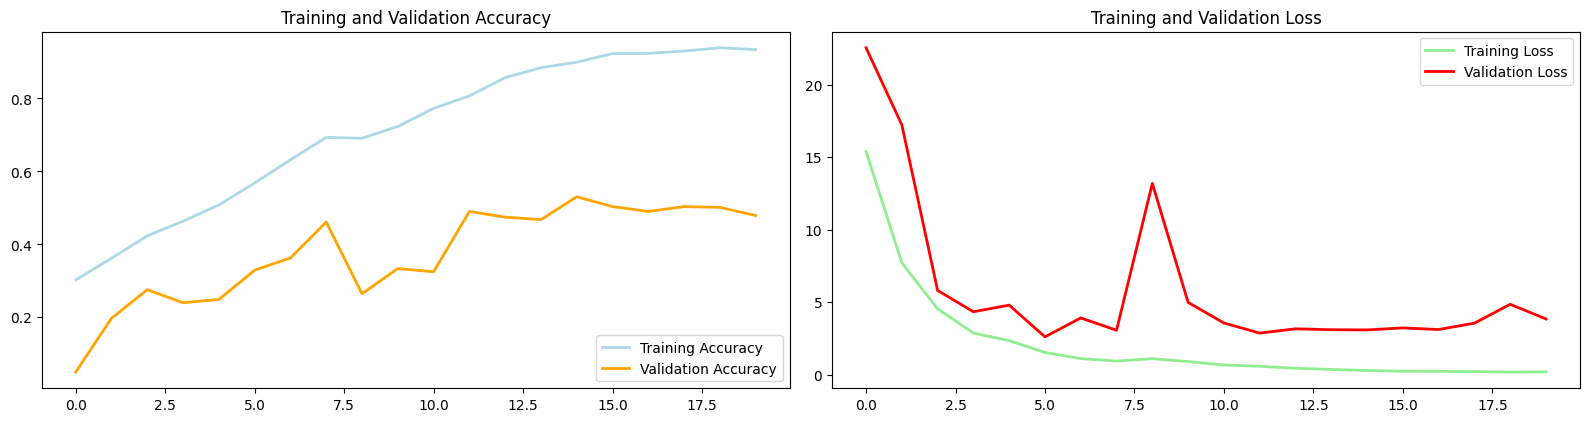

In [27]:
plot_training_history(history, len(history.history['accuracy']))

## Findings after the model fit, that there is an evidence of model overfit or underfit

* Training accuracy of the model seems to increase linearly whereas validation accuracy remained stagnant around 51% 
* High training accuracy means the model has learnt the noise in the data as well, however its poor performance on validation data shows lack of generalisability of the model. 
* The above observations confirm the case of overfitting. To mitigate overfitting augmentation technique will be used. 


#### Analysed the model fit history for presence of underfit or overfit, based on the observations choosing an appropriate data augumentation strategy as discussed below.


Image Data augumented to improve the model performance

* Since the training data available is less, we will generate new samples by slightly modifying the existing training data (for eg. flipping the image horizontally/vertically, slightly rotating the image etc) and use them for training the model as well.

In [28]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [29]:
training_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = class_names,
    batch_size = 64
 )

validation_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = class_names,
    batch_size = 64
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


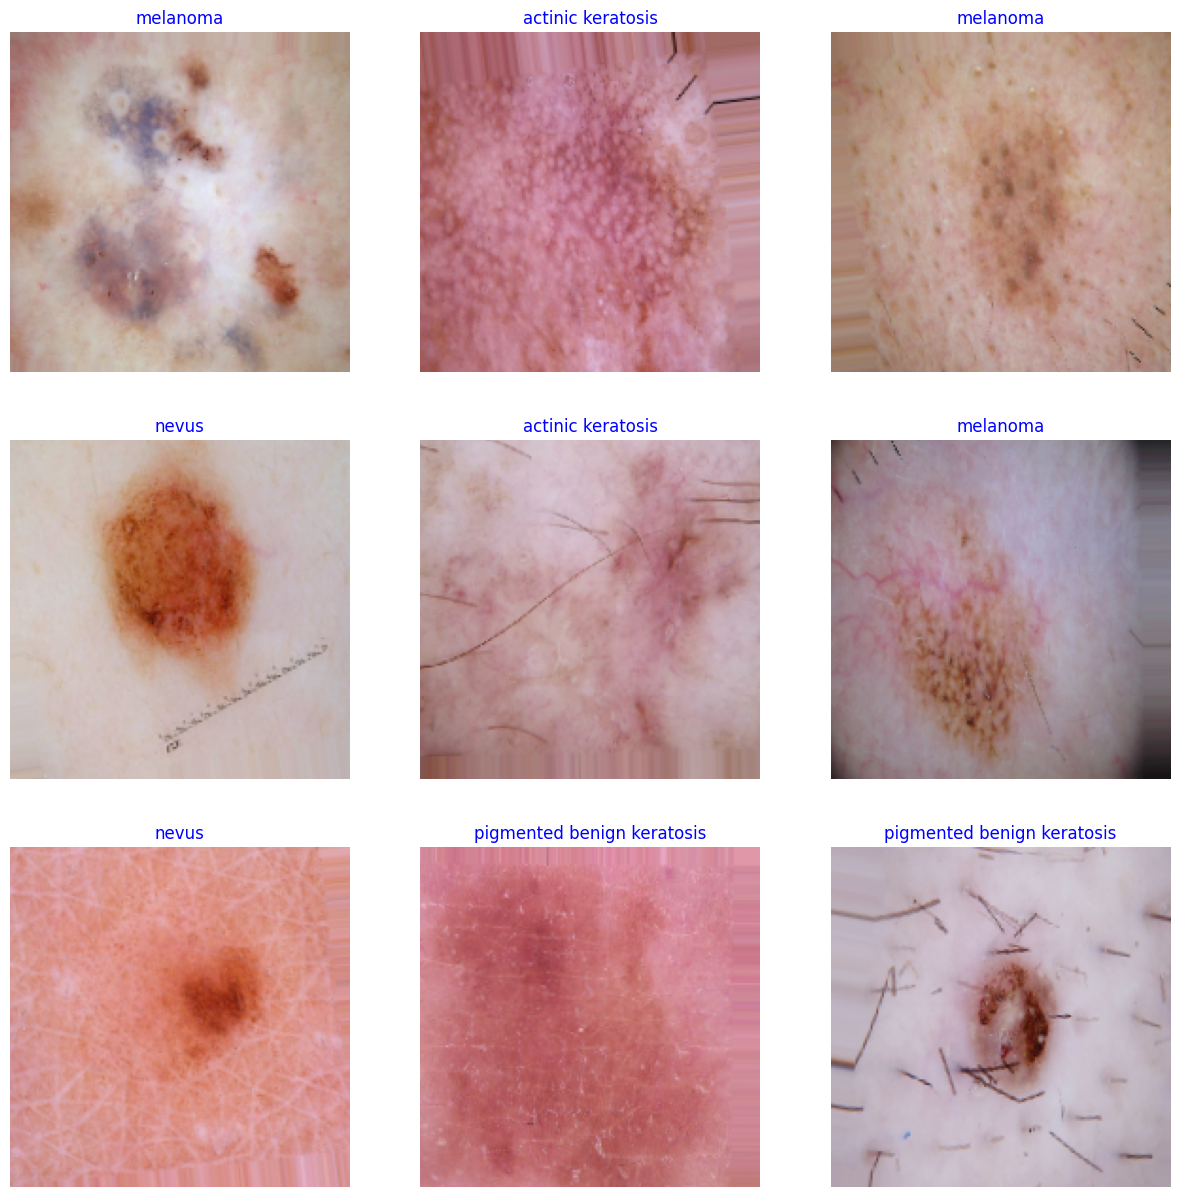

In [30]:
# Now, retrieve the first batch from the dataset (fetch one batch from the generator)
images, labels = next(training_batches)

# Set a larger figure size for bigger images
plt.figure(figsize=(15, 15))  # Increased figure size for larger images

# Visualize first 9 images from the batch
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))   # Display image
    
    # If labels are one-hot encoded, decode using argmax
    label_index = np.argmax(labels[i]) if len(labels[i]) > 1 else labels[i]
    
    # Display the class name as title based on index
    plt.title(class_names[label_index], color="blue")

    plt.axis("off")  # Hide the axis for better visibility

# Show the plot
plt.show()

In [31]:
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [32]:
history = train_model(model, 20, train_ds = training_batches, valid_ds=validation_batches)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.4996 - loss: 2.5901 - val_accuracy: 0.1271 - val_loss: 65.0214
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 887ms/step - accuracy: 0.5305 - loss: 1.6864 - val_accuracy: 0.2966 - val_loss: 8.4512
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 898ms/step - accuracy: 0.5774 - loss: 1.2560 - val_accuracy: 0.2458 - val_loss: 9.8317
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 879ms/step - accuracy: 0.5765 - loss: 1.1713 - val_accuracy: 0.2712 - val_loss: 5.6215
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 891ms/step - accuracy: 0.6123 - loss: 1.0934 - val_accuracy: 0.2542 - val_loss: 7.6125
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 873ms/step - accuracy: 0.6258 - loss: 1.0663 - val_accuracy: 0.3390 - val_loss: 4.4316
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 894ms/step - accuracy: 0.6066 - loss: 1.0732 - val_accuracy: 0.2542 - val_loss: 4.6940
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 876ms/step - accuracy: 0.6394 - loss: 1.0050 - val_accura

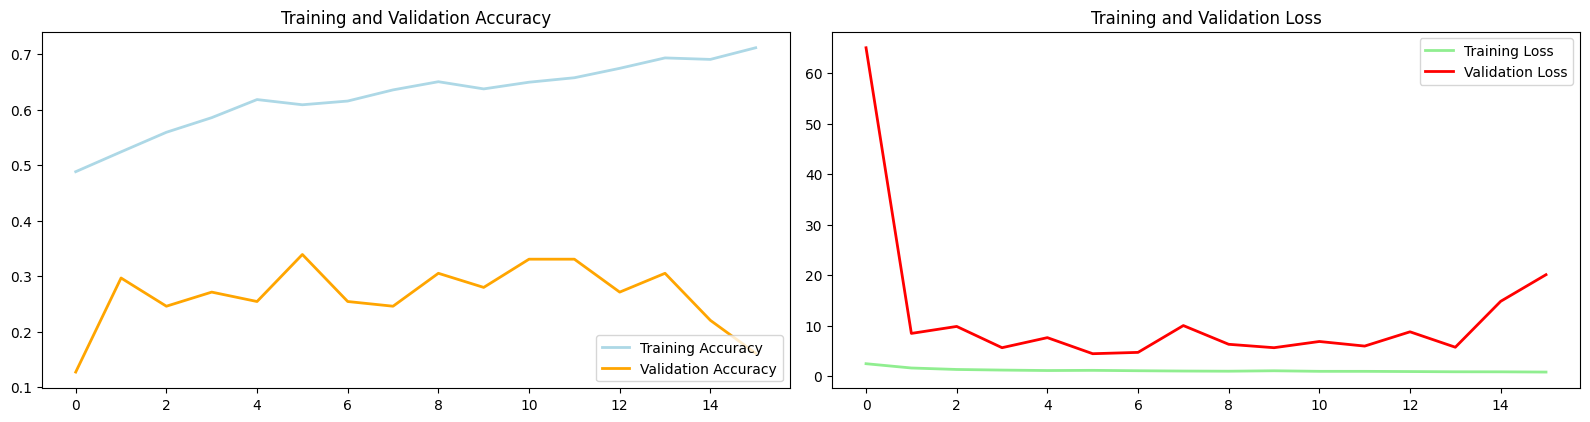

In [33]:
plot_training_history(history, len(history.history['accuracy']))

In [34]:
calculate_metrics(model, train_ds = training_batches, valid_ds=validation_batches)

35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 897ms/step - accuracy: 0.3174 - loss: 7.5728
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.1985 - loss: 18.8474
🔹 **Training Accuracy:** 32.56%
🔹 **Validation Accuracy:** 21.19%
🔹 **Training Loss:** 7.9194
🔹 **Validation Loss:** 19.0213


### Augmentation

Model performance is not improved. So the imbalanced dataset has to be balanced. using augumentations, increasing each class count to 500

### You can use Dropout layer since there is an evidence of overfitting in your findings



In [35]:

input_shape = (180,180,3)
lr = 1e-3
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(7, 7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense (9, activation='softmax'))
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 83, 83, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 83, 83, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 41, 41, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 31, 31, 128)    │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 31, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    14,746,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,844,169 (60.44 MB)

 Trainable params: 15,843,785 (60.44 MB)

 Non-trainable params: 384 (1.50 KB)

In [36]:
history = train_model(model, 20, train_ds = training_batches, valid_ds=validation_batches)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2727 - loss: 15.2239 - val_accuracy: 0.1864 - val_loss: 19.0367
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 855ms/step - accuracy: 0.3435 - loss: 10.0592 - val_accuracy: 0.1441 - val_loss: 17.8752
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 875ms/step - accuracy: 0.3608 - loss: 5.9625 - val_accuracy: 0.0932 - val_loss: 7.9166
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 876ms/step - accuracy: 0.3747 - loss: 4.4754 - val_accuracy: 0.1441 - val_loss: 6.4392
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 873ms/step - accuracy: 0.4100 - loss: 2.5140 - val_accuracy: 0.1441 - val_loss: 5.8998
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 887ms/step - accuracy: 0.4611 - loss: 1.8118 - val_accuracy: 0.2373 - val_loss: 3.6429
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 882ms/step - accuracy: 0.4977 - loss: 1.6924 - val_accuracy: 0.1695 - val_loss: 2.9652
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 895ms/step - accuracy: 0.5114 - loss: 1.4085 - val_acc

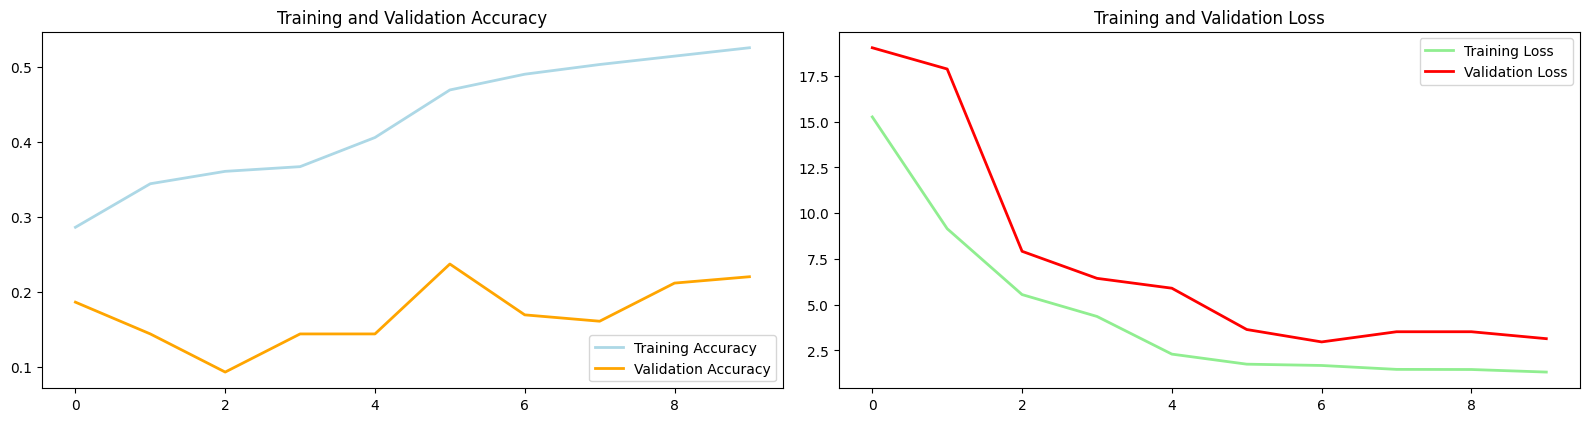

In [37]:
plot_training_history(history, len(history.history['accuracy']))

In [38]:
calculate_metrics(model, train_ds = training_batches, valid_ds=validation_batches)

35/35 ━━━━━━━━━━━━━━━━━━━━ 32s 921ms/step - accuracy: 0.3961 - loss: 1.9849
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2854 - loss: 3.1914
🔹 **Training Accuracy:** 38.37%
🔹 **Validation Accuracy:** 27.97%
🔹 **Training Loss:** 2.0148
🔹 **Validation Loss:** 3.1791


#### Insights:
 
With the help of augmented data, the problem of overfitting is mitigated.
Training and validation accuracy of the above model are in the same range.


## Rectifying the class imbalance
#### **Context:** Using the python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [39]:
!pip install Augmentor

In [40]:
import Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [41]:
!rm -rf "/kaggle/working/augmented_output"

from pathlib import Path  # Import Path if not already imported
import Augmentor

# Assuming data_dir_train is a Path object and a directory containing class folders
path_to_training_dataset = data_dir_train  # Path() automatically handles slashes

# Define a base output directory where augmented files will be stored
output_dir = Path("/kaggle/working/augmented_output")  # Example: '/data/augmented_output'

for i in class_names:
    # Combine the class name with the training data directory
    class_path = path_to_training_dataset / i
    # Combine the class name with the output directory 
    class_output_path = output_dir / i  # Create an output subdirectory for each class

    # Ensure the output subdirectory exists (if not, create it)
    class_output_path.mkdir(parents=True, exist_ok=True)

    # Initialize the Augmentor pipeline
    p = Augmentor.Pipeline(str(class_path), output_directory=str(class_output_path))

    # Define augmentations and sample count
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Add 500 samples per class

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/augmented_output/actinic keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D474C476AD0>: 100%|██████████| 500/500 [00:05<00:00, 84.51 Samples/s] 


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/augmented_output/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D474C406B00>: 100%|██████████| 500/500 [00:06<00:00, 77.02 Samples/s]                   


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/augmented_output/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D474C530640>: 100%|██████████| 500/500 [00:06<00:00, 80.51 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/augmented_output/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D474C49BE80>: 100%|██████████| 500/500 [00:35<00:00, 14.26 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/augmented_output/nevus.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1028x753 at 0x7D47A84D8EE0>: 100%|██████████| 500/500 [00:32<00:00, 15.50 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/augmented_output/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D478044A080>: 100%|██████████| 500/500 [00:06<00:00, 78.94 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/augmented_output/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D47A86FCE20>: 100%|██████████| 500/500 [00:15<00:00, 31.81 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/augmented_output/squamous cell carcinoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D47A871AE60>: 100%|██████████| 500/500 [00:05<00:00, 88.37 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/augmented_output/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D47A8512EC0>: 100%|██████████| 500/500 [00:06<00:00, 82.66 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory for each of the sub-directories(labels) of skin cancer types.. 

Lets take a look at total count of augmented images.

In [42]:
image_count_train = len(list(output_dir.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [43]:
augmented_ds_path = [x for x in glob(os.path.join('/kaggle/working/', 'augmented_output','**','*.jpg'))]
len(augmented_ds_path)

4500

In [44]:
# Collects the names of folders immediately containing the `.jpg` files
augmented_ds_labels = [
    os.path.basename(os.path.dirname(y)) 
    for y in glob(os.path.join('/kaggle/working/augmented_output', '**', '*.jpg'), recursive=True)
]

# Output the subfolder names
len(augmented_ds_labels)

4500

In [45]:
dataframe_dict = dict(zip(augmented_ds_path, augmented_ds_labels))

In [46]:


balanced_train_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
balanced_train_df

Path                 Label
0     /kaggle/working/augmented_output/dermatofibrom...        dermatofibroma
1     /kaggle/working/augmented_output/dermatofibrom...        dermatofibroma
2     /kaggle/working/augmented_output/dermatofibrom...        dermatofibroma
3     /kaggle/working/augmented_output/dermatofibrom...        dermatofibroma
4     /kaggle/working/augmented_output/dermatofibrom...        dermatofibroma
...                                                 ...                   ...
4495  /kaggle/working/augmented_output/seborrheic ke...  seborrheic keratosis
4496  /kaggle/working/augmented_output/seborrheic ke...  seborrheic keratosis
4497  /kaggle/working/augmented_output/seborrheic ke...  seborrheic keratosis
4498  /kaggle/working/augmented_output/seborrheic ke...  seborrheic keratosis
4499  /kaggle/working/augmented_output/seborrheic ke...  seborrheic keratosis

[4500 rows x 2 columns]

In [47]:
# Group by the 'Label' column and then count the occurrences of each label.
balanced_train_df_label_counts = balanced_train_df.groupby('Label').size().reset_index(name='Count_of_Images')

# Display the result
balanced_train_df_label_counts

Label  Count_of_Images
0           actinic keratosis              500
1        basal cell carcinoma              500
2              dermatofibroma              500
3                    melanoma              500
4                       nevus              500
5  pigmented benign keratosis              500
6        seborrheic keratosis              500
7     squamous cell carcinoma              500
8             vascular lesion              500

Old Training Data Distribution
New Balanced Train Data Distribution


<Axes: xlabel='Count_of_Images', ylabel='Label'>

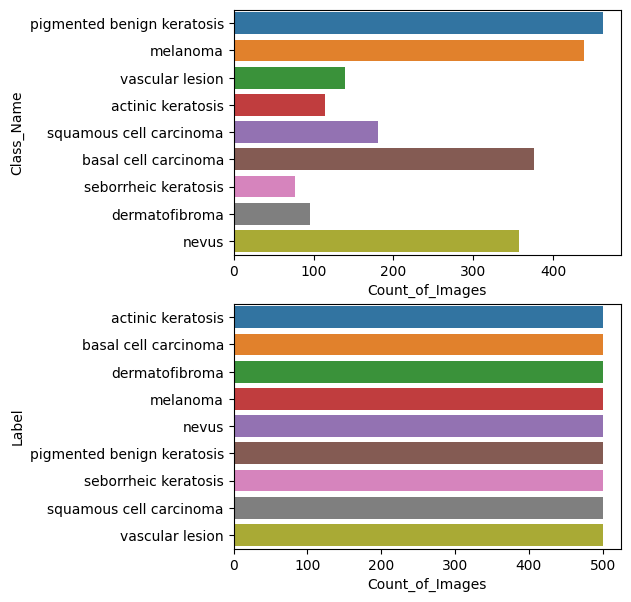

In [48]:

plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
print("Old Training Data Distribution")
sns.barplot(x="Count_of_Images", y="Class_Name", data=train_df,
            label="Label")
plt.subplot(2,1,2)
print("New Balanced Train Data Distribution")
sns.barplot(x="Count_of_Images", y="Label", data=balanced_train_df_label_counts,
            label="Label")

In [49]:
balanced_train_df['Label'].value_counts()

Label
dermatofibroma                500
nevus                         500
basal cell carcinoma          500
melanoma                      500
vascular lesion               500
squamous cell carcinoma       500
actinic keratosis             500
pigmented benign keratosis    500
seborrheic keratosis          500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [50]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a augmented training dataset

In [51]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### Creating a augmented dataset

In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### Create your model (make sure to include normalization)

In [210]:
input_shape = (180,180,3)
lr = 1e-4
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

# Using Data Augmentation Layers eg. RandomCrop, Flip, Translate, Rotate etc.


model.add(RandomRotation(0.3, name='RandomRotation_Layer'))
model.add(RandomZoom(0.2, name='RandomZoom_Layer'))


model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(7, 7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense (9, activation='softmax'))

## Since of classes is 9 using softmax
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RandomRotation_Layer            │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RandomZoom_Layer (RandomZoom)   │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 41, 41, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 2, 2, 256)      │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,005,385 (7.65 MB)

 Trainable params: 2,004,361 (7.65 MB)

 Non-trainable params: 1,024 (4.00 KB)

#### Compiling the model (using optimizer and loss function appropriately)

In [211]:
## cleanup old checkpoint

In [212]:
!rm "/kaggle/working/model.keras"

In [213]:
# Compile the model with optimizer, loss function, and metrics
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Set up the ModelCheckpoint. This saves the best model (with highest validation accuracy).
checkpoint = ModelCheckpoint("/kaggle/working/model.keras", 
                             monitor="val_accuracy", 
                             save_best_only=True, 
                             mode="auto", 
                             verbose=1)

# Set up early stopping, which stops the training when the validation accuracy plateaus.
earlystop = EarlyStopping(monitor="val_accuracy", 
                          patience=10, 
                          mode="auto", 
                          verbose=1)



### Now you can use these callbacks in model.fit()

#### Training the model using checkpoints to capture the progress iteratively

In [214]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3252 - loss: 1.9201
Epoch 1: val_accuracy improved from -inf to 0.10111, saving model to /kaggle/working/model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.3256 - loss: 1.9185 - val_accuracy: 0.1011 - val_loss: 2.8165
Epoch 2/30
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4026 - loss: 1.5621
Epoch 2: val_accuracy improved from 0.10111 to 0.10556, saving model to /kaggle/working/model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.4031 - loss: 1.5612 - val_accuracy: 0.1056 - val_loss: 2.5495
Epoch 3/30
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4447 - loss: 1.4724
Epoch 3: val_accuracy improved from 0.10556 to 0.18222, saving model to /kaggle/working/model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.4453 - loss: 1.4714 - val_accuracy: 0.1822 - val_loss: 2.7284
Epoch 4/30
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4888 - loss: 1.3590


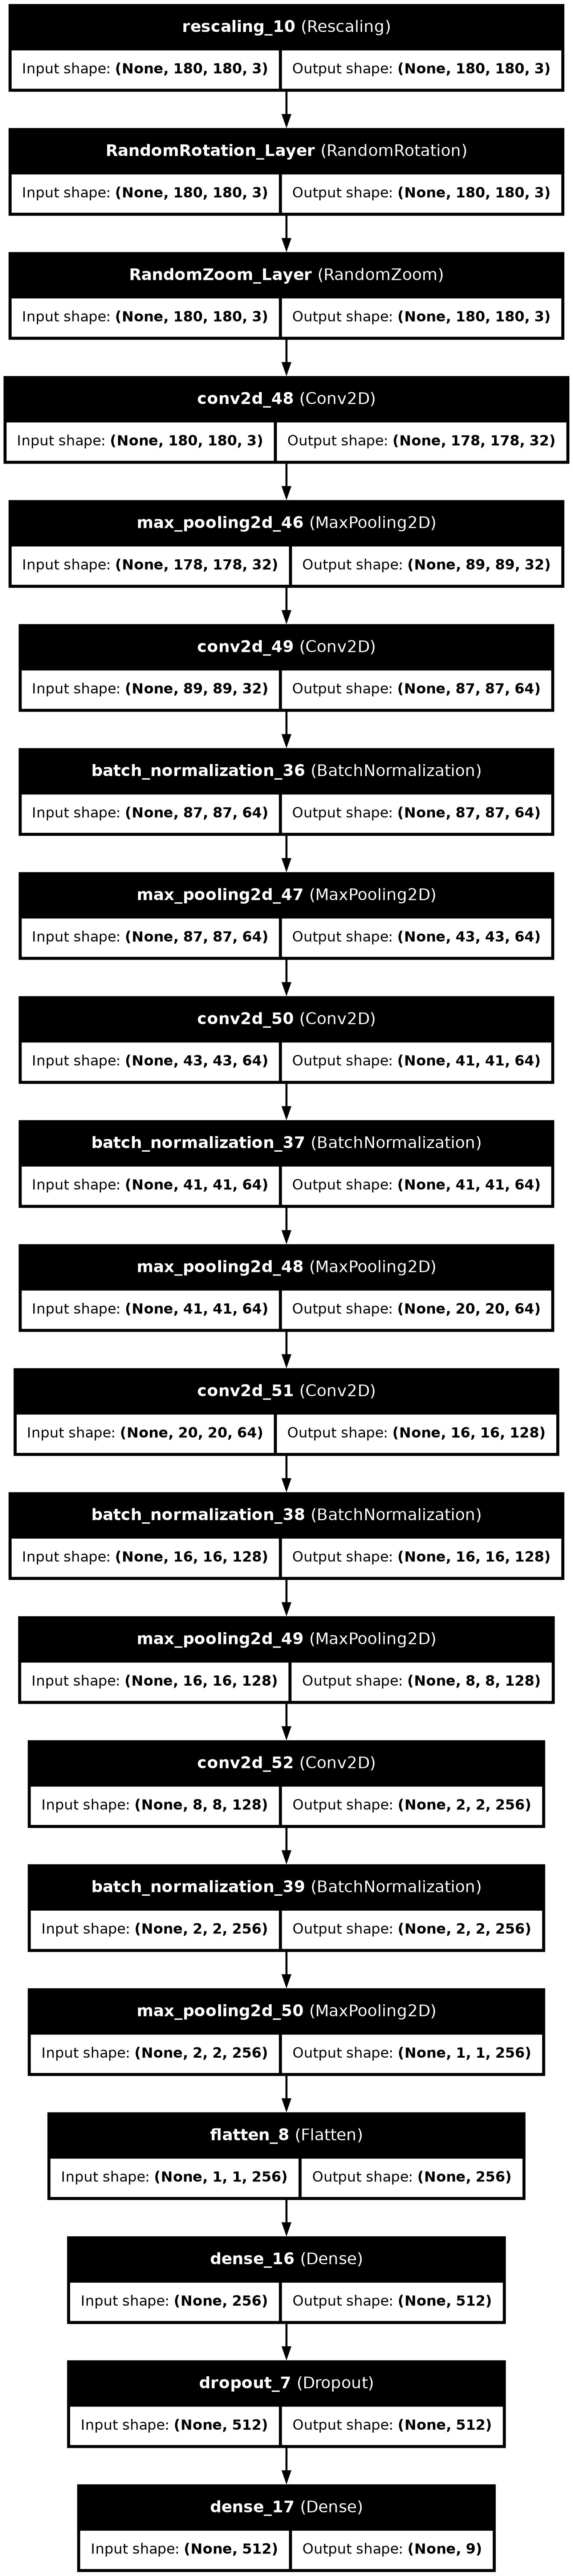

In [215]:
# plotting the model layers
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Visualize the model results

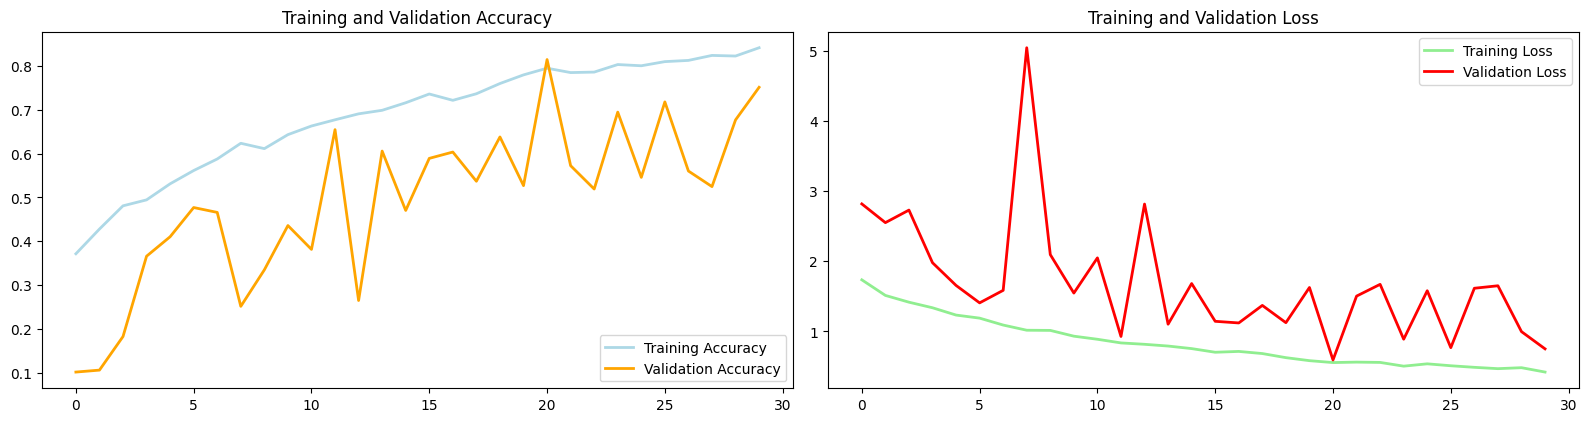

In [216]:
plot_training_history(history, len(history.history['accuracy']))

In [217]:
calculate_metrics(model, train_ds, val_ds)

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7917 - loss: 0.5197
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7608 - loss: 0.7448
🔹 **Training Accuracy:** 81.03%
🔹 **Validation Accuracy:** 75.11%
🔹 **Training Loss:** 0.4833
🔹 **Validation Loss:** 0.7506


#### Analysis of the results here. Did we get rid of underfitting/overfitting? Did class rebalance help us?



### Observations on the CNN Model After Rebalancing the Classes of Melanoma

Based on the charts and the metrics above, here's a detailed breakdown of the observations:

---

#### 1. **Training and Validation Accuracy (Left Plot):**

- **Steady Increase in Training Accuracy:**
  The light blue line (Training Accuracy) shows a steady and consistent improvement over the 30 epochs. 
  - By the 30th epoch, the training accuracy reaches **81.03%**, indicating that the model is learning from the rebalanced dataset and improving its prediction capability on the training set.
  
- **Fluctuations in Validation Accuracy:**
  The yellow/orange line (Validation Accuracy) shows a fluctuating behavior. While there is an increasing trend, we observe sharp peaks and drops throughout the training process. This suggests:
    - **Epoch Overfitting:** The model fits very well during certain epochs but may be overfitting some parts of the dataset, leading to sudden drops in validation accuracy.
    - **Less Stable Validation Performance:** By the 30th epoch, validation accuracy reaches **75.11%**, which is still good but highlights slight instability in performance across various epochs.

---

#### 2. **Training and Validation Loss (Right Plot):**

- **Smooth Decrease in Training Loss (Green Line):**
  The training loss shows a steady decrease, which is expected when the model improves its learning during training. By the 30th epoch, the training loss is down to **0.4833**, confirming that the model is learning and minimizing the errors during training.

- **Spiking and Fluctuating Validation Loss (Red Line):**
  The validation loss is highly volatile, showing multiple peaks and drops. This is consistent with the behavior of the fluctuating validation accuracy. Some sharp spikes in validation loss can be seen between Epochs 10 and 15.
    - The **instability in validation loss** may indicate that the model is not generalizing well at certain epochs due to the rebalancing of classes.
    - However, the overall trend shows a **decreasing pattern**, ending with a **validation loss of 0.7506** in the last epoch. 
    - **Erratic peaks** are an indicator of overfitting or sensitivity to class rebalancing, meaning the model may perform worse when tested against unseen data.

---

#### 3. **Final Model Metrics (Post-Rebalancing):**

- **Training Accuracy:** **81.03%**
  - This shows that the model has learned to predict the target labels with reasonable accuracy on the training data.
  
- **Validation Accuracy:** **75.11%**
  - A 75% validation accuracy points toward a reasonable generalization capability, though there is room for improvement. The gap between training accuracy and validation accuracy (~6%) suggests slight overfitting but not very severe.

- **Training Loss:** **0.4833**
  - A fairly low training loss, meaning the model fits the training data quite well.

- **Validation Loss:** **0.7506**
  - There is a noticeable difference between training and validation loss. The **difference of ~0.27** confirms that validation data still challenges weak generalization, requiring more fine-tuning, and rebalancing might have introduced instability.

---



### Summary

- The CNN model's training performance is solid, showcasing an **81.03% training accuracy** and a **validation accuracy of 75.11%** after class rebalancing.
- **Instability** in validation accuracy and loss suggests that despite rebalancing, the model encounters difficulty generalizing consistently.
- Modifications such as early stopping, learning rate tuning, and stronger regularization strategies might reduce overfitting and boost the model's generalization to unseen melanoma data.
- Less differences between train and validation accuracies indicate that model has not overfitted
- Have used dropouts and maxpooling to reduce overfitting and increase stability
- Training Loss reduces below 0.5. However, Validation loss shows downward trend initially but increases gradually after 30 epochs
- As compared to the previous Models, this model performed better than former Models



### Vizualizing how our augmentation strategy works for one instance of training image.

## Identify a image from test data for the given class

In [298]:

class_names=os.listdir(data_dir_test)
class_num=5  # sample class
Test_image_path = os.path.join(pathlib.Path(data_dir_test), class_names[class_num], '*')
Test_image_path


'/kaggle/input/av-cnn-melonoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test/basal cell carcinoma/*'

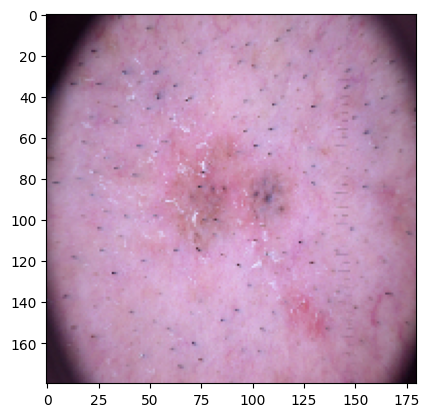

In [299]:
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)
img = np.expand_dims(Test_image,axis=0)

### Predicting using the model on the test data

### Util function to generate a prediction result for a given prediction probability

In [300]:
def generate_result(prob):
    pred = np.argmax(prob)
    pred_class = class_names[pred]
    print("Actual Class "+ class_names[class_num] +'\n'+ "Predictive Class "+pred_class )

In [302]:
# # Load the saved model (Architecture + Weights). 
# # Assume your model checkpoint is saved as 'model_checkpoint.h5'
# checkpoint_model = load_model('/kaggle/working/model.keras')

# # Assuming you have a preprocessed image (img) in a format that your model accepts:
# # Feed the image to the model.
# prob = checkpoint_model.predict(img)
# generate_result(prob)

In [301]:
prob = model.predict(img)
generate_result(prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma
